<a href="https://colab.research.google.com/github/asarria48/Nuclear-physics/blob/main/Informe3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Preparación

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit

<>:46: SyntaxWarning: invalid escape sequence '\g'
<>:46: SyntaxWarning: invalid escape sequence '\g'
/tmp/ipython-input-2403283608.py:46: SyntaxWarning: invalid escape sequence '\g'
  plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)


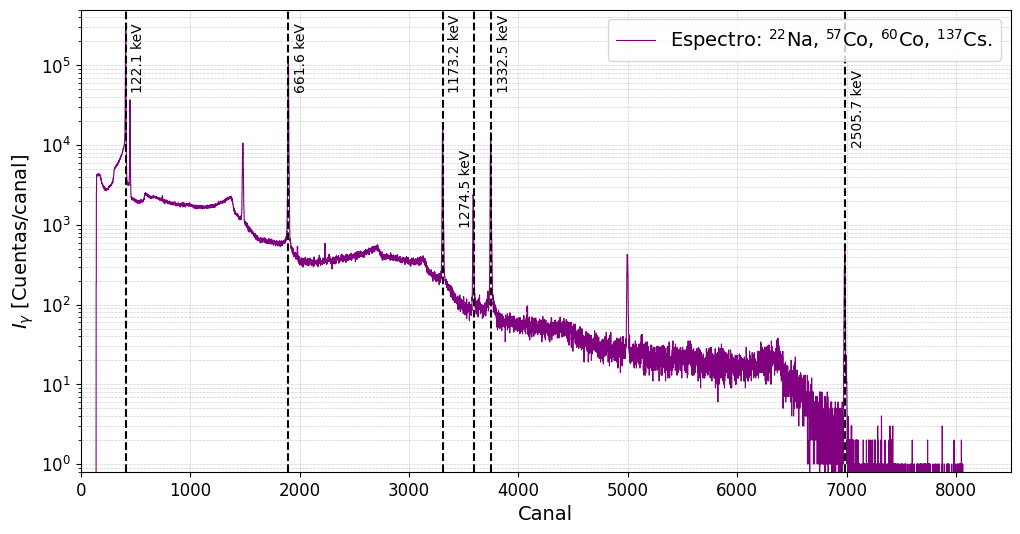

In [128]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# leo los espectros
varios = pd.read_csv("calibracionNaCoCoCs-Ge8K.xy", sep=r"\s+", header=None)
euro = pd.read_csv("calibracionEu-Ge8K.xy", sep=r"\s+", header=None)

# nombres de columnas
varios.columns = ["canal", "cuentas"]
euro.columns = ["canal", "cuentas"]

df = varios                                                                     # por ahora solo me interesan estos espectros

plt.figure(figsize=(12,6))
plt.plot(df["canal"], df["cuentas"], ds="steps-mid", color='purple', lw=0.8, label="Espectro: $^{22}$Na, $^{57}$Co, $^{60}$Co, $^{137}$Cs.")
plt.tick_params(axis='both', which='major', labelsize=12)
plt.tick_params(axis='both', which='minor', labelsize=12)

# aquí meto los picos "a ojo" que ya conozco

plt.axvline(410, color='black', lw=1.5,linestyle='--')
plt.text(410 + 50, 1e4*5, f'122.1 keV', color='black',rotation=90, fontsize=10)     # del cobalto 57

plt.axvline(1895, color='black', lw=1.5,linestyle='--')
plt.text(1895 + 50, 1e4*5, f'661.6 keV', color='black',rotation=90, fontsize=10)    # del cesio 137

plt.axvline(3310, color='black', lw=1.5,linestyle='--')
plt.text(3310 + 50, 1e4*5, f'1173.2 keV', color='black',rotation=90, fontsize=10)   # "primero" del cobalto 60

plt.axvline(3750, color='black', lw=1.5,linestyle='--')
plt.text(3750 + 50, 1e4*5, f'1332.5 keV', color='black',rotation=90, fontsize=10)   # "segundo" del cobalto 60

plt.axvline(6985, color='black', lw=1.5,linestyle='--')
plt.text(6985 + 50, 1e4, f'2505.7 keV', color='black', rotation=90, fontsize=10)    # resultado de la suma de los dos picos del cobalto 60

plt.axvline(3590, color='black', lw=1.5,linestyle='--')
plt.text(3590 - 130, 1e3, f'1274.5 keV', color='black',rotation=90, fontsize=10)    # del sodio 22


plt.xlim(0, 8500)
plt.yscale("log")
plt.ylim(0.8, 5e5)

plt.xlabel("Canal", fontsize=14)
plt.ylabel("$I_\gamma$ [Cuentas/canal]", fontsize=14)
plt.legend(fontsize=14)
plt.grid(which="both", linestyle="--", linewidth=0.5, alpha=0.6)
plt.show()


# Calibraciones


=== Parámetros ===
μ        = 1896.497(20)
σ        = 2.173(22)
FWHM     = 5.097(52)
Int      = 617917(81)


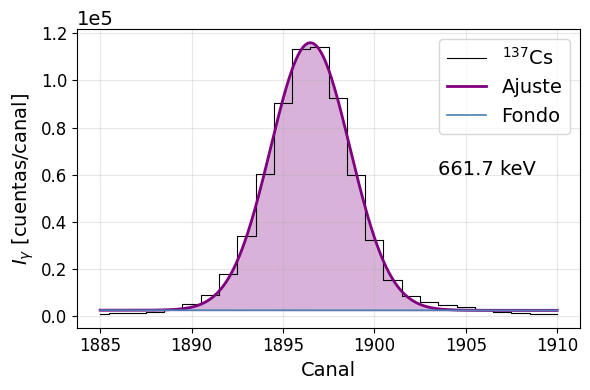

In [173]:
def leer_xy(archivo):
    data = pd.read_csv(archivo, sep=r"\s+", header=None, names=["canal", "cuentas"])
    return data

archivo = "calibracionNaCoCoCs-Ge8K.xy"
data = leer_xy(archivo)

x = data['canal'].values
y = data['cuentas'].values

def gauss_bg(x, mu, sigma, A, a0, a1):                                                   # ajuste gaussiano con fondo lineal
    return A * np.exp(-0.5 * ((x - mu) / sigma)**2) + a0 + a1 * x


def fwhm(sigma): return 2.3458 * sigma                                                             # FWHM
def dfwhm(dsigma): return 2.3458 * dsigma                                                          # incertidumbre del FWHM
def intensidad(A, sigma): return A * sigma * np.sqrt(2 * np.pi)                                   # I
def dintensidad(A, sigma, dA, dsigma):                                                            # incertidumbre de I
    return np.sqrt((sigma * np.sqrt(2*np.pi) * dA)**2 + (A * np.sqrt(2*np.pi) * dsigma)**2)



def format_unc(value, error):                                                                     # incertidumbre en forma compacta
    if error == 0 or np.isnan(error):
        return f"{value:.4g}"
    exp_err = int(np.floor(np.log10(abs(error))))
    digits = max(0, -exp_err + 1)
    value_rounded = round(value, digits)
    err_rounded = int(round(error * 10**(-exp_err + 1)))
    if digits > 0:
        return f"{value_rounded:.{digits}f}({err_rounded})"
    else:
        return f"{int(round(value_rounded))}({err_rounded})"

# Pico de 661 keV
x_min, x_max = 1885, 1910
mask = (x >= x_min) & (x <= x_max)
x_region, y_region = x[mask], y[mask]

mu2_guess = x_region[np.argmax(y_region)]
A2_guess = y_region.max()
sigma2_guess = 4.0
a0_guess2 = np.median(y_region)
a1_guess2 = 0.0
p0_2 = [mu2_guess, sigma2_guess, A2_guess, a0_guess2, a1_guess2]

popt2, pcov2 = curve_fit(gauss_bg, x_region, y_region, p0=p0_2, maxfev=10000)
perr2 = np.sqrt(np.diag(pcov2))


print("\n=== Parámetros ===")
μ, σ, A, a0, a1 = popt2
dμ, dσ, dA, da0, da1 = perr2
labels2 = ["μ", "σ", "FWHM", "Int"]
values2 = [μ, σ, fwhm(σ), intensidad(A, σ)]
errors2 = [dμ, dσ, dfwhm(dσ), dintensidad(A, σ, dA, dσ)]


for lbl, val, err in zip(labels2, values2, errors2):
    print(f"{lbl:8s} = {format_unc(val, err)}")


xf = np.linspace(x_region.min(), x_region.max(), 800)
fit = gauss_bg(xf, *popt2)
bg = popt2[3] + popt2[4] * xf


for (xr, yr, xf, fit, bg, color, title) in [
    (x_region, y_region, xf, fit, bg, "purple", "Pico ($^{137}$Cs)")
]:
    fig, ax = plt.subplots(figsize=(6, 4))

    ax.step(xr, yr, where='mid', color='black', lw=0.8, label='$^{137}$Cs')
    ax.plot(xf, fit, color=color, lw=2, label='Ajuste')
    ax.plot(xf, bg, color='steelblue', lw=1.2, label='Fondo')
    ax.fill_between(xf, bg, fit, where=(fit > bg), color=color, alpha=0.3)

    ax.set_xlabel("Canal", fontsize=14)
    ax.set_ylabel("$I_\\gamma$ [cuentas/canal]", fontsize=14)


    ax.ticklabel_format(style='sci', axis='y', scilimits=(0, 0))
    ax.yaxis.get_offset_text().set_fontsize(14)

    ax.tick_params(axis='both', labelsize=12)

    ax.legend(fontsize=14)
    plt.text(1903.5, 0.6*1e5, '661.7 keV', fontsize=14)
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
